# ESCO Skill-Occupation Matrix Tables <-> ILO Scenarios
Felix Zaussinger, 14.05.2021

## Core Analysis Goal(s)
1. Match ESCO Skill-Occupation Matrix Tables (1.2, 2.2, 3.2) to ILO green
transition scenarios to project skill demand at an aggregate level

## Key Insight(s)
1. Matching is rather straightforward. As one possible method, changes in the
demand for certain skill groups may be approximated by multiplying occupational
skill importance weights by net employment change. This creates a crude numeric
equivalence between employment change and skill demand change. To be seen if
this constitutes a viable way forward.

In [107]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("paper")
#sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
# https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values
def show_values_on_bars(axs, h_v="v", space=0.4, formatter='{:.2f}'):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = formatter.format(p.get_height())
                ax.text(_x, _y, value, ha="center")
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = formatter.format(p.get_width())
                ax.text(_x, _y, value, ha="left", va="bottom")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

Define directory structure

In [2]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

Read ILO green transition scenario data

In [3]:
fpath_ilo = os.path.join(data_raw, "ilo_scenarios", "ilo_empl_scenarios_2030.xlsx")

ilo_scenarios = ["energy_sustainability", "circular_economy"]
df_ilo = pd.read_excel(
    io=fpath_ilo,
    sheet_name=ilo_scenarios
)

# convert to millions and calculate net employment change
scale_factor = 1000
numeric_cols = ['new_jobs_absorbing', 'new_jobs_net', 'jobs_lost_net', 'jobs_lost_reallocated', 'net_change']

for ilo_scenario in ilo_scenarios:
    df_ilo[ilo_scenario][numeric_cols] *= scale_factor
    # df_ilo[ilo_scenario]["net_change"] = df_ilo[ilo_scenario].new_jobs_net + df_ilo[ilo_scenario].jobs_lost_net

Text(0.5, 1.0, 'circular_economy')

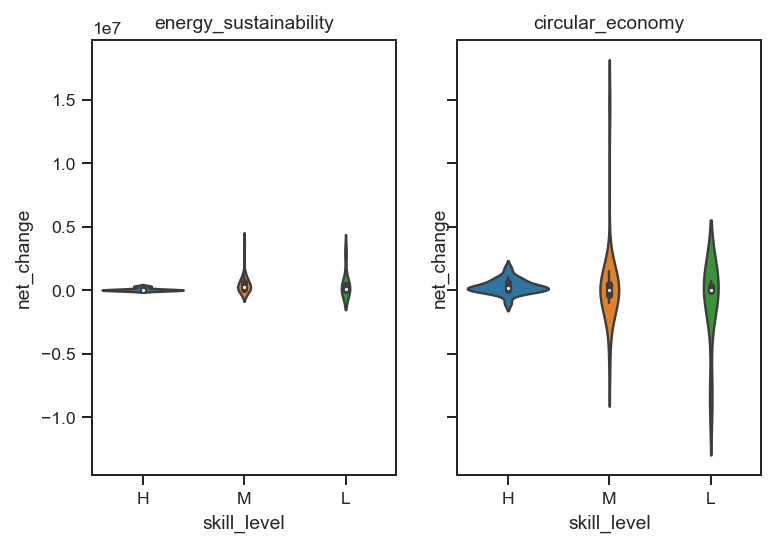

In [4]:
fig, axes = plt.subplots(ncols=2, sharey=True)

sns.violinplot(
    x="skill_level",
    y="net_change",
    data=df_ilo["energy_sustainability"],
    ax=axes[0]
).set_title("energy_sustainability")

sns.violinplot(
    x="skill_level",
    y="net_change",
    data=df_ilo["circular_economy"],
    ax=axes[1]
).set_title("circular_economy")

Read ESCO skills-occupation matrix tables

In [5]:
fpath_esco = os.path.join(data_raw, "esco", "en_Skills_Occupations Matrix Tables.xlsx")

sheet_names = ["Matrix 1.2", "Matrix 2.2", "Matrix 3.2"]

df_esco = pd.read_excel(
    io=fpath_esco,
    sheet_name=sheet_names,
    header=1
)

# name unnamed cols
for sheet_name in sheet_names:
    df_esco[sheet_name].rename(columns={'Unnamed: 0': "uri", 'Unnamed: 1': "occupation"}, errors="raise", inplace=True)

# extract isco codes and add as column
isco_codes_raw = df_esco["Matrix 1.2"].iloc[:,0].str.split("/", expand=True)
isco_codes_clean = isco_codes_raw.iloc[:, 5].str.replace("C", "")

for sheet_name in sheet_names:
    df_esco[sheet_name].insert(0, "isco_code", pd.to_numeric(isco_codes_clean))

### Join ILO data to ESCO matrix.

Visualisation test 1: multiply skill group weights by net employment change to obtain a proxy of skill demand change

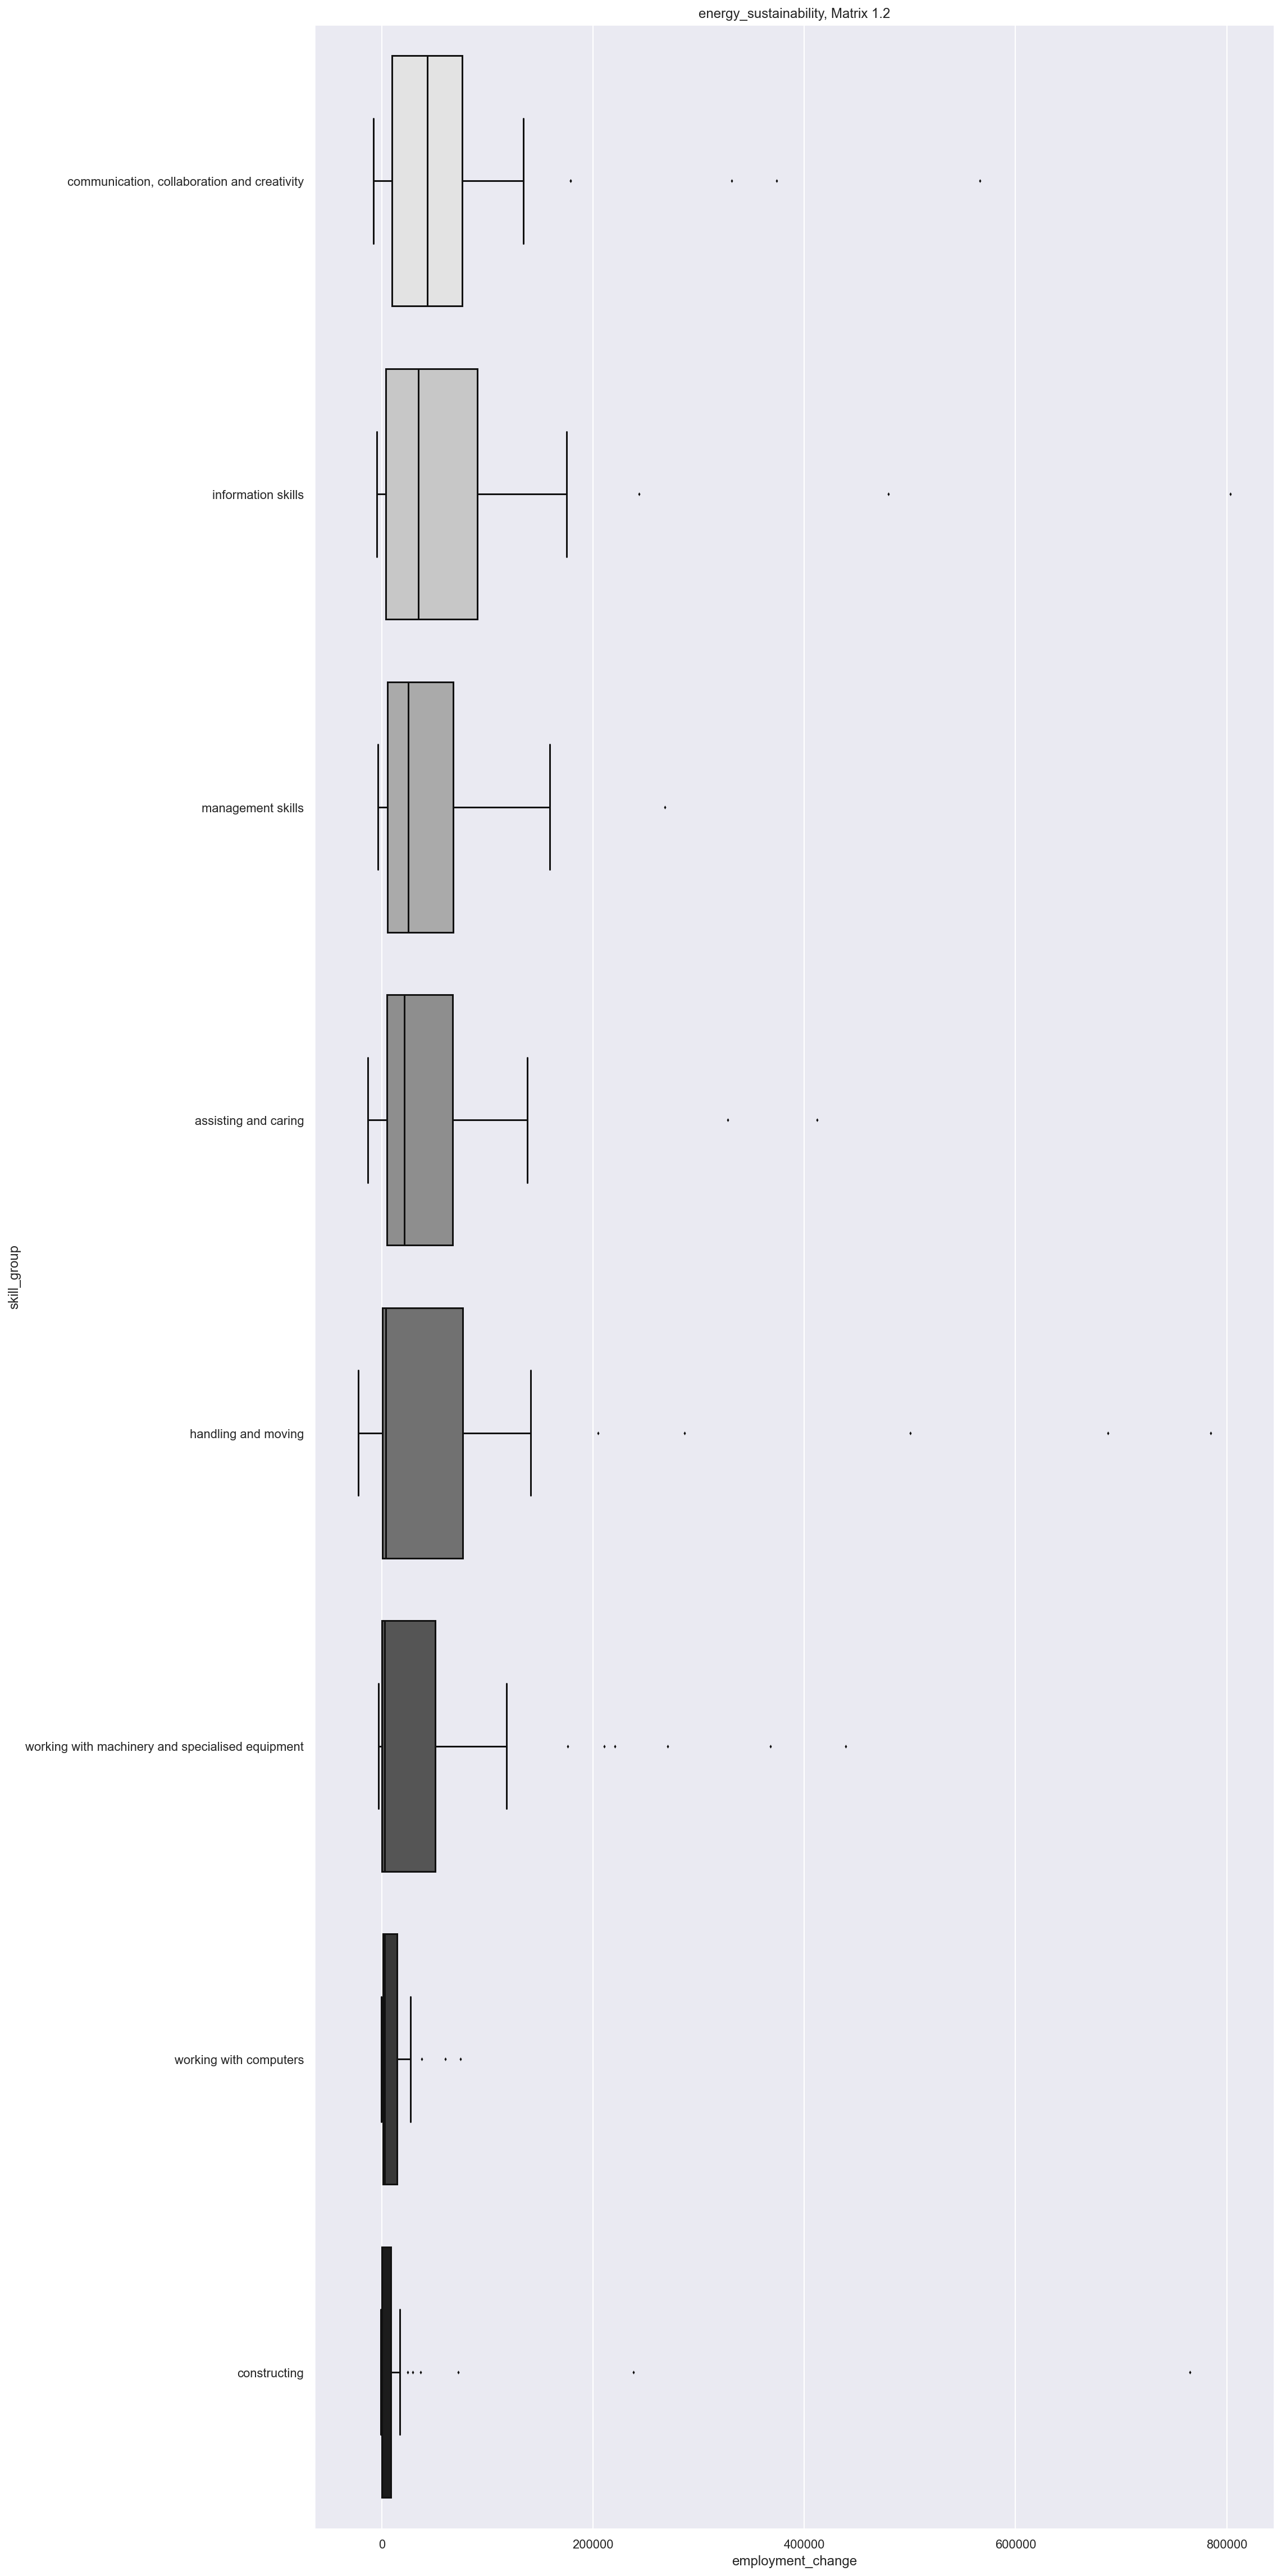

In [9]:
sns.set(rc={'figure.figsize': (16, 32.)})

# data selection
scenario = "energy_sustainability"  # circular_economy, energy_sustainability
esco_matrix = "Matrix 1.2"

# check if all weights sum up to 1
df_esco[esco_matrix].iloc[:,3:].sum(axis=1).all()

# extract skill groups
skill_groups = list(df_esco[esco_matrix].columns[3:].values)

# merge ILO and ESCO data
esco_ilo_es = pd.merge(
    left=df_esco[esco_matrix],
    right=df_ilo[scenario],
    on="isco_code",
    how="left",
    validate="one_to_one"
).dropna(subset=numeric_cols, how="all")

# estimate skill-group share of net employment change as a proxy for skill
# demand change
skill_demand_change = esco_ilo_es[skill_groups].multiply(esco_ilo_es["net_change"], axis=0)

# wide to long
skill_demand_change_long = skill_demand_change.melt(var_name="skill_group", value_name="employment_change")

# plot
title = "{}, {}".format(scenario, esco_matrix)
sns.boxplot(
    y="skill_group",
    x="employment_change",
    orient="h",
    fliersize=1,
    palette="binary",
    order=list(skill_demand_change.median().sort_values(ascending=False).index.values),
    data=skill_demand_change_long
).set_title(title)

# save plot
plt.tight_layout()
plt.savefig(
    fname=os.path.join(figure_dir, title + ".png"),
    dpi=150,
    format="png"
)

#### Apply same approach as for IEA scenario

In [69]:
# read occ-skills matrix
occ_skills_matrix_eo = pd.read_pickle(
        os.path.join(project_dir, "data", "processed", "adjacency_matrix_essential_optional.pkl")
)

# weights: essential = 1, optional = 0.5
occ_skills_matrix_eo = occ_skills_matrix_eo.replace(to_replace=2, value=0.5)

In [30]:
# read occupations to extract isco codes
occ = pd.read_csv(
    os.path.join(project_dir, "data", "raw", "esco", "v1.0.3", "occupations_en.csv"),
)

occ["isco_lvl_2"] = occ.iscoGroup.astype(str).str.slice(0, 2).astype(int)

,conceptType,conceptUri,iscoGroup,preferredLabel,altLabels,hiddenLabels,status,modifiedDate,regulatedProfessionNote,scopeNote,definition,inScheme,description,isco_lvl_2
0,Occupation,http://data.europa.eu/esco/occupation/00030d09...,2166,technical director,technical and operations director\nhead of tec...,NaN,released,2016-07-05T13:58:41Z,http://data.europa.eu/esco/regulated-professio...,NaN,NaN,http://data.europa.eu/esco/concept-scheme/occu...,Technical directors realise the artistic visio...,21
1,Occupation,http://data.europa.eu/esco/occupation/000e93a3...,8121,metal drawing machine operator,metal drawing machine technician\nmetal drawin...,NaN,released,2016-07-05T17:09:43Z,http://data.europa.eu/esco/regulated-professio...,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Metal drawing machine operators set up and ope...,81
2,Occupation,http://data.europa.eu/esco/occupation/0019b951...,7543,precision device inspector,inspector of precision instruments\nprecision ...,NaN,released,2016-07-06T09:21:20Z,http://data.europa.eu/esco/regulated-professio...,NaN,NaN,http://data.europa.eu/esco/concept-scheme/occu...,Precision device inspectors make sure precisio...,75
3,Occupation,http://data.europa.eu/esco/occupation/0022f466...,3155,air traffic safety technician,air traffic safety electronics hardware specia...,NaN,released,2017-01-17T11:40:37Z,http://data.europa.eu/esco/regulated-professio...,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Air traffic safety technicians provide technic...,31
4,Occupation,http://data.europa.eu/esco/occupation/002da35b...,2431,hospitality revenue manager,hospitality revenues manager\nyield manager\nh...,NaN,released,2017-01-17T13:33:42Z,http://data.europa.eu/esco/regulated-professio...,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Hospitality revenue managers maximise revenue ...,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,Occupation,http://data.europa.eu/esco/occupation/ff656b3a...,2120,demographer,demography research analyst\ndemography studie...,NaN,released,2016-07-05T16:21:57Z,http://data.europa.eu/esco/regulated-professio...,NaN,NaN,http://data.europa.eu/esco/concept-scheme/occu...,Demographers study a variety of parameters rel...,21
2938,Occupation,http://data.europa.eu/esco/occupation/ff8d4065...,9612,sorter labourer,grader\nyard labourer\nrecycler\nrecycling sit...,NaN,released,2017-01-17T13:22:45Z,http://data.europa.eu/esco/regulated-professio...,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Sorter labourers sort recyclable materials and...,96
2939,Occupation,http://data.europa.eu/esco/occupation/ffa4dd5d...,5414,armoured car guard,van escort\narmoured truck guard\ncar escort\n...,NaN,released,2016-12-22T10:57:58Z,http://data.europa.eu/esco/regulated-professio...,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Armoured car guards ensure the safe transporta...,54
2940,Occupation,http://data.europa.eu/esco/occupation/ffade2f4...,2422,civil service administrative officer,government administrative officer\nlocal autho...,NaN,released,2016-07-05T16:17:26Z,http://data.europa.eu/esco/regulated-professio...,NaN,NaN,http://data.europa.eu/esco/concept-scheme/occu...,Civil service administrative officers perform ...,24


In [34]:
skills_uris = occ_skills_matrix_eo.columns.values

array(['http://data.europa.eu/esco/skill/0005c151-5b5a-4a66-8aac-60e734beb1ab',
       'http://data.europa.eu/esco/skill/00064735-8fad-454b-90c7-ed858cc993f2',
       'http://data.europa.eu/esco/skill/000709ed-2be5-4193-b056-45a97698d828',
       ...,
       'http://data.europa.eu/esco/skill/fff0e2cd-d0bd-4b02-9daf-158b79d9688a',
       'http://data.europa.eu/esco/skill/fff5bc45-b506-4466-8977-4869079c1cb2',
       'http://data.europa.eu/esco/skill/fff74a70-4f82-4949-9c3b-b335904cf927'],
      dtype=object)

In [132]:
scenario = "circular_economy"  # circular_economy, energy_sustainability

In [133]:
occ_merged = pd.merge(
    occ,
    df_ilo[scenario].loc[:, ["isco_code", "net_change"]],
    left_on="isco_lvl_2",
    right_on="isco_code",
    how="left"
)

occ_merged = occ_merged.set_index("conceptUri")

In [134]:
# multiply every skills column with net change estimate
assert all(occ_merged.index == occ_skills_matrix_eo.index)
occ_skills_matrix_eo_multiplied = occ_skills_matrix_eo.multiply(occ_merged.net_change, axis=0)

In [135]:
# calculate average over all occupations
skills_delta = occ_skills_matrix_eo_multiplied.mean(axis=0)
skills_delta.name = "demand_change"
skills_delta = skills_delta.reset_index()

In [136]:
skills = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skills_en.csv"))

In [137]:
# map skill names to uri's
all(skills.conceptUri.values == skills_delta.conceptUri.values)
skills_delta["preferredLabel"] = skills.preferredLabel

In [138]:
# sort by demand change and plot
n_skills = 15

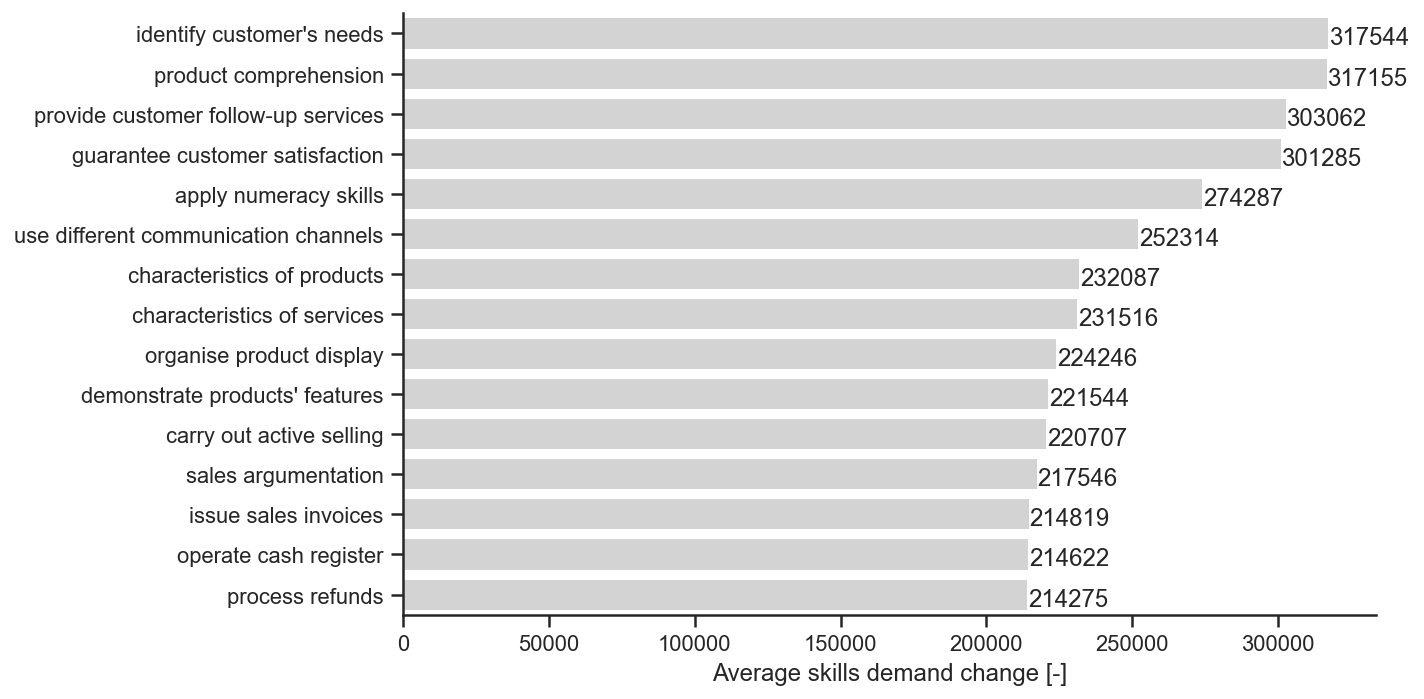

In [141]:
with sns.plotting_context(font_scale=1.5):

    fig, ax = plt.subplots(figsize=(10, 5))

    sns.barplot(
        data=skills_delta.sort_values("demand_change", ascending=False).head(n_skills),
        y="preferredLabel",
        x="demand_change",
        orient="h",
        color="lightgrey",
        ax=ax
    )

    ax.set_xlabel("Average skills demand change [-]")
    ax.set_ylabel(None)
    #ax.set_title("Top 30 skills")

    show_values_on_bars(ax, h_v="h", formatter='{:.0f}', space=0)

    plt.tight_layout()
    sns.despine()

    plt.savefig(
        os.path.join(figure_dir, "ilo_scenario", "top_skills_mean_{}.png".format(scenario)),
        bbox_inches="tight",
        dpi=300
    )

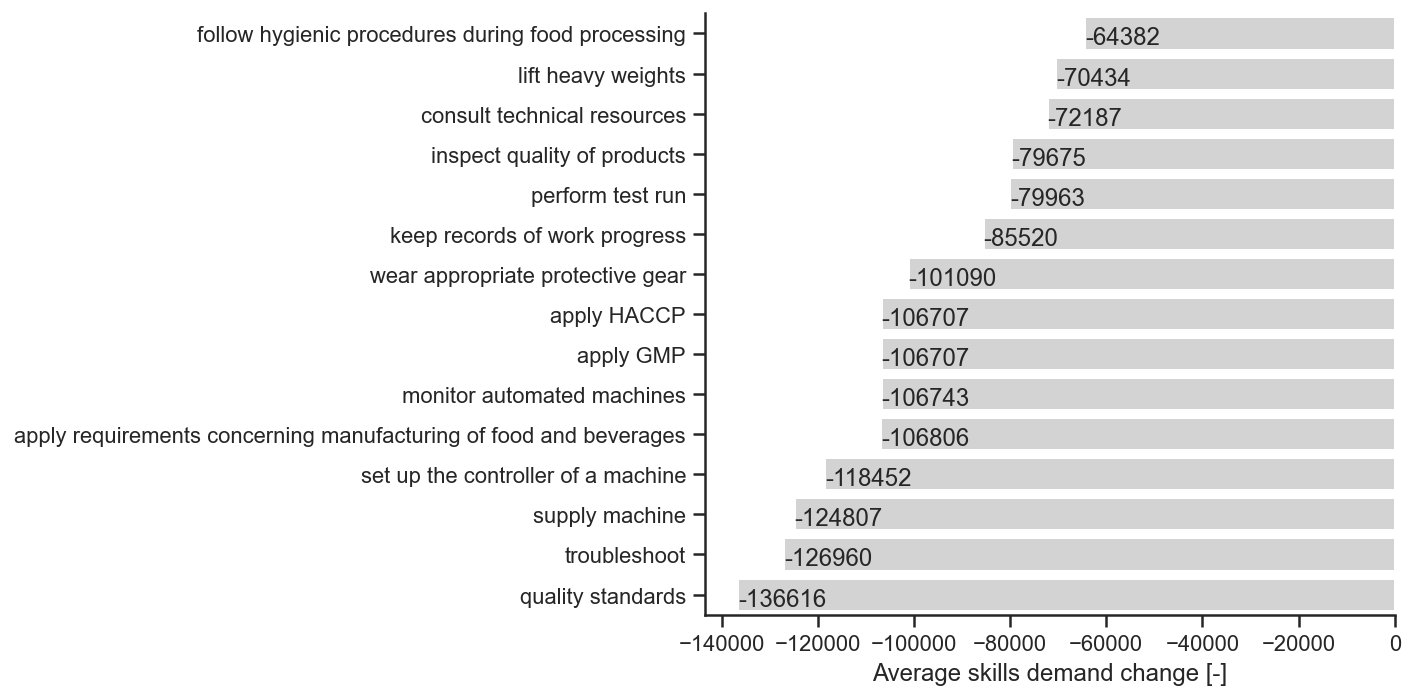

In [144]:
with sns.plotting_context(font_scale=1.5):

    fig, ax = plt.subplots(figsize=(10, 5))

    sns.barplot(
        data=skills_delta.sort_values("demand_change", ascending=False).tail(n_skills),
        y="preferredLabel",
        x="demand_change",
        orient="h",
        color="lightgrey",
        ax=ax
    )

    ax.set_xlabel("Average skills demand change [-]")
    ax.set_ylabel(None)
    #ax.set_title("Top 30 skills")

    show_values_on_bars(ax, h_v="h", formatter='{:.0f}', space=0)

    plt.tight_layout()
    sns.despine()

    plt.savefig(
        os.path.join(figure_dir, "ilo_scenario", "bottom_skills_mean_{}.png".format(scenario)),
        bbox_inches="tight",
        dpi=300
    )